## Load documents with IDs

In [1]:
import requests

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [2]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

## Load ground truth

In [3]:
import pandas as pd
base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [4]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [5]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Index data

In [6]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [13]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|██████████████████████| 948/948 [00:56<00:00, 16.78it/s]


## Retrieval

In [14]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)


In [15]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))


[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

## The RAG flow

In [16]:
def build_prompt(query, search_results):
    prompt_template = """
    You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
    Use only the facts from the CONTEXT when answering the QUESTION.
    
    QUESTION: {question}
    
    CONTEXT: 
    {context}
    """.strip()

    context = ""

    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [20]:
from openai import OpenAI

client = OpenAI()

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content


In [21]:
# previously: rag(query: str) -> str
def rag(query: dict, model = 'gpt-4o') ->str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [22]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [23]:
rag(ground_truth[10])

"Yes, sessions are recorded, so you won't miss anything if you are unable to attend. You will also be able to ask your questions for office hours in advance, and they will be covered during the live stream. Additionally, you can ask questions in Slack."

In [24]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric

In [20]:
answer_orig = 'Yes, if you miss a session, everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance, and they will be covered during the live stream. Additionally, you can always ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

np.float32(0.8867048)

In [21]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [22]:
len(ground_truth)

1830

In [23]:
answer = {}

In [51]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answer:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answer[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],

    }

 13%|██▍                | 232/1830 [10:15<1:10:40,  2.65s/it]


KeyboardInterrupt: 

In [53]:
result_gpt4o = [None] * len(ground_truth)
for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[I].update(ground_truth[i])

232

In [15]:
import pandas as pd

In [ ]:
df_gpt4o = pd.Dataframe(results_gpt4o)

In [16]:
!mkdir data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

## Evaluating GPT 3.5

In [22]:
rag(ground_truth[10], model='gpt-3.5-turbo')

'Yes, sessions are recorded if you miss one. Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and they will be covered during the live stream.'

In [28]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

    for future in futures:
        result = future.result()
        results.append(result)

    return results

In [12]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }


In [26]:
process_record(ground_truth[10])

{'answer_llm': 'Yes, sessions are recorded if you miss one. You can watch the recorded sessions to catch up on any missed content.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [ ]:
results_gpt35 = map_progress(pool, ground_truth, process_record)

In [ ]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

In [27]:
!head data/results-gpt35.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


answer_llm,answer_orig,document,question,course
You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"I am sorry, but there is no direct link provided in the FAQ database for signing up for the course. However, you can find a link in the course GitHub repository at this address: https://airtable.com/shryxwLd0COOEaqXo.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this 

## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A,A')

## GPT 4.0

In [35]:
df_gpt4o = pd.read_csv('data/results-gpt4o.csv')

In [36]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [37]:
record = results_gpt4o[0]

In [65]:
def cosine_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [39]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = cosine_similarity(record)
    similarity.append(sim)

100%|████████████████████| 1830/1830 [01:43<00:00, 17.67it/s]


In [42]:
df_gpt4o['cosine']= similarity

In [43]:
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153425
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [24]:
import seaborn as sns

/tmp/ipykernel_9730/2967343473.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

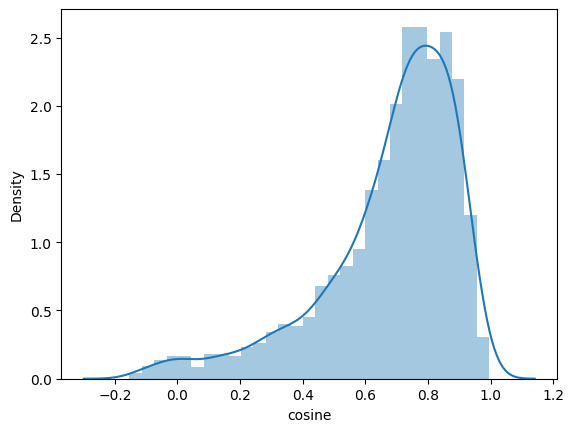

In [25]:
sns.distplot(df_gpt4o['cosine'])

## GPT 3.5-turbo

In [29]:
df_gpt35 = pd.read_csv('data/results-gpt35.csv')
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = cosine_similarity(record)
    similarity_35.append(sim)    


100%|████████████████████| 1830/1830 [01:21<00:00, 22.49it/s]


In [31]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [45]:
import matplotlib.pyplot as plt

/tmp/ipykernel_9730/1445141376.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label = '4o')
/tmp/ipykernel_9730/1445141376.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label = '3.5')


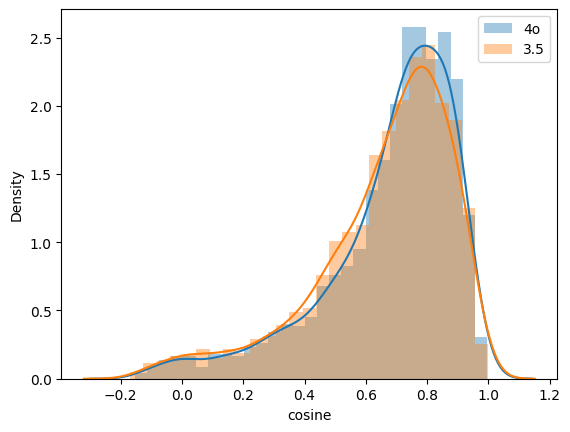

In [47]:
sns.distplot(df_gpt4o['cosine'], label = '4o')
sns.distplot(df_gpt35['cosine'], label = '3.5')

plt.legend()

## gpt-4o-mini

In [59]:
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }


In [60]:
process_record_4o_mini(ground_truth[10])

{'answer_llm': 'Yes, sessions are recorded, so if you miss one, you won’t miss anything. You will have the opportunity to ask your questions for office hours in advance, and they will be covered during the live stream. Additionally, you can always ask questions in Slack.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [ ]:
results_gpt4omini = []

In [ ]:
for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

In [ ]:
df_gpt4omini = pd.DataFrame(results_gpt4omini)
df_gpt4omini.to_csv('data/results-gpt4omini.csv', index=False)

In [26]:
df_gpt4o_mini = pd.read_csv('data/results-gpt4o-mini.csv')


In [66]:
df_gpt4o_mini = pd.read_csv('data/results-gpt4o-mini.csv')
results_gpt4omini = df_gpt4omini.to_dict(orient='records')
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = cosine_similarity(record)
    similarity_4o_mini.append(sim)

100%|████████████████████| 1830/1830 [01:30<00:00, 20.29it/s]


In [68]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

/tmp/ipykernel_9730/3577767862.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label = '4o')
/tmp/ipykernel_9730/3577767862.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label = '3.5')
/tmp/ipykernel_9730/3577767862.py:3: UserWarning: 

`distplot

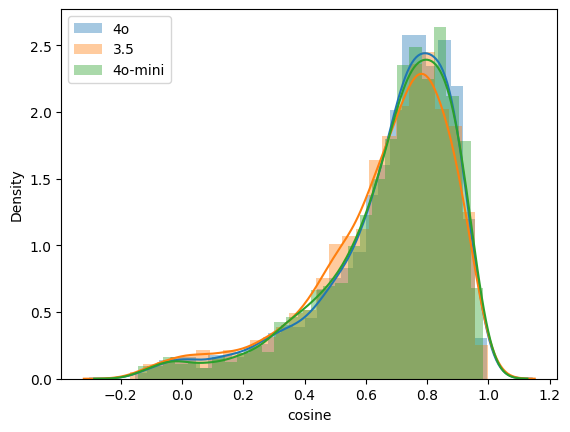

In [69]:
sns.distplot(df_gpt4o['cosine'], label = '4o')
sns.distplot(df_gpt35['cosine'], label = '3.5')
sns.distplot(df_gpt4omini['cosine'], label = '4o-mini')

plt.legend()

## LLM-as-a-Judge

In [27]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()


In [28]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [29]:
samples = df_sample.to_dict(orient='records')

In [30]:
record = samples[0]

In [31]:
prompt = prompt1_template.format(**record)

In [32]:
answer = llm(prompt, model='gpt-4o-mini')

In [33]:
import json

In [34]:
json.loads(answer)

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer directly addresses the question about the syntax for using `precision_recall_fscore_support` in Python. It provides the exact code snippet as in the original answer, demonstrating its correct usage, which signifies a high level of relevance and similarity.'}

In [35]:
answers = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    answer = llm(prompt, model = 'gpt-4o-mini')
    answers.append(answer)

100%|██████████████████████| 150/150 [06:55<00:00,  2.77s/it]


In [36]:
json_answers = []

for i, str_answer in enumerate(answers):
    print(f"Parsing answer {i}: {str_answer}")
    json_answer = json.loads(str_answer)
    json_answers.append(json_answer)

Parsing answer 0: {
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly provides the syntax for using `precision_recall_fscore_support` in Python, which matches the context and content of the original answer. It includes the same code snippet and effectively addresses the generated question."
}
Parsing answer 1: {
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses how to modify scripts to avoid pickle errors when using waitress, mirroring the original answer's solution. It succinctly summarizes the core advice given in the original text, explaining the need to place the custom class in a separate module and to import it in both relevant scripts. Thus, it aligns closely with the content and intent of the original response."
}
Parsing answer 2: {
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer accurately captures the essence of the original answer by providing the correct command to launch a container image in int

In [51]:
df_evaluations = pd.DataFrame(json_answers)

In [52]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           122
PARTLY_RELEVANT     17
NON_RELEVANT        11
Name: count, dtype: int64

In [54]:
df_evaluations[df_evaluations.Relevance =='NON_RELEVANT']#.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer addresses a different iss...
11,NON_RELEVANT,The generated answer addresses a different err...
27,NON_RELEVANT,The generated answer incorrectly states that t...
41,NON_RELEVANT,The original answer refers to accessing a link...
44,NON_RELEVANT,The generated answer addresses a different que...
87,NON_RELEVANT,The generated answer addresses a different asp...
90,NON_RELEVANT,The generated answer addresses a different que...
93,NON_RELEVANT,The generated answer does not address the cont...
116,NON_RELEVANT,The original answer pertains to accessing a li...
138,NON_RELEVANT,The generated answer addresses a different iss...


In [55]:
samples[4]

{'answer_llm': "The cause of the pip version error in this week's serverless deep learning section could be a version conflict in Scikit-Learn. Specifically, if you are using a different version than what was used during the model training, it can lead to warnings and potential breaking code or invalid results. To resolve this, make sure to use the same version of Scikit-Learn that was used for training the model. For instance, if you trained with version 1.1.1, you should use that same version in your virtual environment.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://github.com/alexeygrigorev/tflite-aws-lambda/raw

In [57]:
llm(prompt, model = 'gpt-4o-mini')

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer directly addresses the modification made to the `median_house_value` target by explaining that it was changed to a binary format, specifying the transformation from a continuous to a discrete variable. It also provides context about why this change was necessary, connecting it to the calculation of mutual information, which is pertinent to the question asked."\n}'

In [58]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model = 'gpt-4o-mini')
    evaluations.append(evaluation)

100%|██████████████████████| 150/150 [07:19<00:00,  2.93s/it]


In [59]:
json_evaluations_2 = []

for i, str_answer in enumerate(evaluations):
    json_answer = json.loads(str_answer)
    json_evaluations_2.append(json_answer)

Parsing answer 0: {
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer provides the exact syntax for using the `precision_recall_fscore_support` function in Python, along with a brief code example. It addresses the question directly and is fully aligned with the request for syntax."
}
Parsing answer 1: {
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question about modifying scripts to avoid pickle errors when using waitress. It provides a specific solution involving the organization of code into separate modules, which is an appropriate method to handle pickle-related issues in this context."
}
Parsing answer 2: {
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question by providing the correct command to launch a container image in interactive mode, specifying both the command 'docker run -it' and the use of '--entrypoint bash', which are relevant to achieving the desired outcome."
}
Par

In [61]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [62]:
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           126
PARTLY_RELEVANT     22
NON_RELEVANT         2
Name: count, dtype: int64

In [65]:
df_evaluations_2[df_evaluations_2.Relevance=='NON_RELEVANT']#.to_dict(orient='records')

,Relevance,Explanation
45,NON_RELEVANT,The generated answer states that it cannot pro...
102,NON_RELEVANT,The generated answer addresses the issue of im...


In [67]:
samples[45]

{'answer_llm': 'The provided context does not include specific commands to start the Docker daemon on Linux. Therefore, I cannot provide an answer based solely on the facts from the context.',
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of these commands:\nsudo dockerd\nsudo service docker start\nAdded by Ugochukwu Onyebuchi',
 'document': '4b2a3181',
 'question': 'What commands should I use to start the docker daemon on Linux?',
 'course': 'machine-learning-zoomcamp'}

In [ ]:
df_gpt4o.to_csv('data/results-gpt4o-cosine.csv', index=False)
df_gpt35.to_csv('data/results-gpt35-cosine.csv', index=False)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini-cosine.csv', index=False)

In [ ]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)